## Aux_operators

In [3]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import numpy as np
import pprint

from qiskit import Aer
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, CG
from qiskit.chemistry import QiskitChemistryError
from qiskit.chemistry.applications import MolecularGroundStateEnergy
from qiskit.chemistry.algorithms import ground_state_solvers
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.core import QubitMappingType, Hamiltonian, TransformationType
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, HFMethodType
from qiskit.circuit.library import TwoLocal
from qiskit.tools.visualization import circuit_drawer

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import IBMQ
provider = IBMQ.load_account()

from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

ibmqfactory.load_account:WARNING:2021-06-13 14:21:58,716: Credentials are already in use. The existing account in the session will be replaced.


In [5]:
def add_unitary_gate(circuit,qubit1,qubit2,params,p0):
    circuit.s(qubit1)
    circuit.s(qubit2)
    circuit.h(qubit2)
    circuit.cx(qubit2,qubit1)
    circuit.u3(params[p0],params[p0+1],params[p0+2],qubit1); p0 += 3
    circuit.u3(params[p0],params[p0+1],params[p0+2],qubit2); p0 += 3
    circuit.cx(qubit2,qubit1)
    circuit.h(qubit2)
    circuit.sdg(qubit1)
    circuit.sdg(qubit2) 

class SO_04(VariationalForm):
    
    def __init__(self, numqubits):
        self._num_qubits = numqubits
        self._num_parameters = 6*(numqubits-1)
               
    def construct_circuit(self, parameters):
        q = QuantumRegister(self._num_qubits, name='q')
        circ = QuantumCircuit(q)
        
        #initial state       
        #circ.x(0)
        #circ.x(1)
        
        if self._num_qubits == 4:        
            add_unitary_gate(circ, 0, 1, parameters, 0)
            add_unitary_gate(circ, 2, 3, parameters, 6)
            add_unitary_gate(circ, 1, 2, parameters, 12)
            
        return circ
    
    @property
    def num_parameters(self):
        return self._num_parameters    

In [12]:
# ricorda i parametri
lastparam = {}
lastparam['TwoLocal(ry)'] = np.ones(12)   
lastparam['SO(4)'] = np.ones(18)   

In [19]:
def vqe_function(geometry, basis = 'sto-6g', var_form_type = 'TwoLocal(ry)', 
                 quantum_instance = Aer.get_backend("statevector_simulator"),
                 optimizer = CG(maxiter=1000)):
    
    two_qubit_reduction = True
    qubit_mapping = 'parity'
    
    charge = 1
    spin = 0
    driver = PySCFDriver(atom = geometry,
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis=basis,hf_method=HFMethodType.RHF)
    
    molecule = driver.run()
    
    shift = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_orbitals = molecule.num_orbitals
    num_spin_orbitals = num_orbitals*2
    
    
    core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                   two_qubit_reduction=two_qubit_reduction, freeze_core=False)

    qubitOp, aux_ops = core.run(molecule)
    
    aux_ops = aux_ops[:3]
    aux_ops.append(qubitOp)
    
    initial_state = HartreeFock(num_spin_orbitals, 
                                num_particles, 
                                qubit_mapping,
                                two_qubit_reduction)
    
    var_form = TwoLocal() #dummy
    init_parm = lastparam[var_form_type]
    
    if var_form_type == 'TwoLocal(ry)':
        var_form = TwoLocal(rotation_blocks=['ry'], entanglement_blocks='cx',
                            num_qubits=4,
                            reps=2,
                            #initial_state=initial_state,
                            entanglement='linear')
        
    if var_form_type == 'TwoLocal(ry_rz)':
        var_form = TwoLocal(rotation_blocks=['ry','rz'], entanglement_blocks='cz',
                            num_qubits=4,
                            #initial_state=initial_state,
                            entanglement='linear')
    
    if var_form_type == 'UCCSD':
        var_form = UCCSD(num_orbitals=num_spin_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction,
                        z2_symmetries=None)
        
    if var_form_type == 'SO(4)':
        var_form = SO_04(4)
    
      
    
    vqe = VQE(qubitOp, var_form, optimizer, initial_point=init_parm,aux_operators=aux_ops)
    vqe_result_tot = vqe.run(quantum_instance)
    
    return vqe_result_tot

In [21]:
dist = np.arange(0.3, 3.5, .1)
alt = np.sqrt(dist**2 - (dist/2)**2)

num_elettroni = []


for i in range(len(dist)):
    geometry = "H .0 .0 .0; H .0 .0 " + str(dist[i]) + "; H .0 " + str(alt[i]) + " " + str(dist[i]/2)
    
    result = vqe_function(geometry)
    
    num_elettroni.append(result['aux_operator_eigenvalues'][0,0])
    
    print("D = ", dist[i], "\t NUM = ", result['aux_operator_eigenvalues'][0,0])  #numero part, spinz, spin2

D =  0.3 	 NUM =  2.000003884238438
D =  0.4 	 NUM =  2.000005868120518
D =  0.5 	 NUM =  2.0000098831342616
D =  0.6000000000000001 	 NUM =  2.0000000003947336
D =  0.7000000000000002 	 NUM =  2.0000308975819165
D =  0.8000000000000003 	 NUM =  2.000047709290114
D =  0.9000000000000001 	 NUM =  2.000070388431731
D =  1.0000000000000002 	 NUM =  2.0001048771111476
D =  1.1000000000000003 	 NUM =  2.00016710907478
D =  1.2000000000000004 	 NUM =  2.000252683104788
D =  1.3000000000000005 	 NUM =  2.000441514611321
D =  1.4000000000000004 	 NUM =  2.000000022801021
D =  1.5000000000000004 	 NUM =  3.99999996642285
D =  1.6000000000000005 	 NUM =  3.999999809572163
D =  1.7000000000000004 	 NUM =  3.999999887404674
D =  1.8000000000000005 	 NUM =  3.9999999920458036
D =  1.9000000000000006 	 NUM =  3.9999999981181533
D =  2.0000000000000004 	 NUM =  3.999999999422563
D =  2.1000000000000005 	 NUM =  3.999999999897866
D =  2.2000000000000006 	 NUM =  3.9999999922768437
D =  2.3000000000000

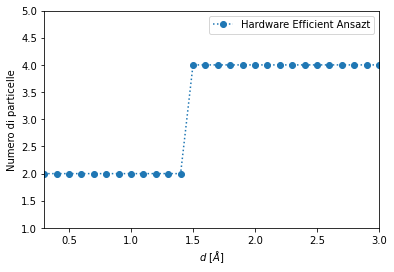

In [40]:
yerr = []
for i in dist:
    yerr.append(0.1)
    
plt.plot(dist,num_elettroni,"o:",label="Hardware Efficient Ansazt")
    
plt.xlabel(r"$d$ $[\AA]$")
plt.ylabel(r"Numero di particelle")
plt.legend()
plt.ylim([1, 5])
plt.xlim([0.3, 3])


#plt.ylim([-1.3, .0])
#plt.xlim([0.5, 1.5])

#plt.title('SIMULAZIONI VQE SENZA RUMORE E SENZA INITIAL STATE')
plt.savefig('figura.pdf')
plt.show()